Predicción de gastos médicos en SparkR
===

* *30 min* | Última modificación: Junio 22, 2019

En este tutorial se presentan los comandos fundamentales para construir un modelo de regresión lineal para la predicción de gastos médicos por parte de una aseguradora usando SparkR.

## Definición del problema

Una compañía de seguros desea pronósticar los gastos médicos de la población asegurada con el fin de recolectar un valor superior en ingresos, tal que le permita obtener utilidades. Los costos son difíciles de pronósticar ya que las condiciones más costosas son más raras y parecen aleatorias; y que ciertas condiciones son más probables para ciertos segmentos de la población (infarto en personas obesas y cáncer en fumadores).

El objetivo es usar una base de datos con 1338 registros de gastos médicos hipotéticos para pacientes de EU con el fin de estimar los costos para determinados segmentos de la población. La información registrada es la siguiente:

* Age: entero hasta 64.

* Sex: male, female.

* bmi: Body mass index.

* children: entero indicando la cantidad de hijos/dependientes cubiertos por el plan de salud.

* smoker: yes, no.

* region: northest, southeast, southwest, northwest.

* charges: costos.


## Solución

### Preparación

In [1]:
##
## Esta función se usará para ejecutar comandos en el 
## sistema operativo y capturar la salida.
##
systemp <- function(command) cat(system(command, intern = TRUE), sep = '\n')

In [2]:
##
## Se procede a la carga de la librería
##
library(SparkR)
sparkR.session(enableHiveSupport = TRUE)


Attaching package: ‘SparkR’

The following objects are masked from ‘package:stats’:

    cov, filter, lag, na.omit, predict, sd, var, window

The following objects are masked from ‘package:base’:

    as.data.frame, colnames, colnames<-, drop, endsWith, intersect,
    rank, rbind, sample, startsWith, subset, summary, transform, union

Spark package found in SPARK_HOME: /usr/local/spark-2.4.0


Launching java with spark-submit command /usr/local/spark-2.4.0/bin/spark-submit   sparkr-shell /tmp/Rtmp6lSMIr/backend_port3f4e3ad21f00 


Warning message in sparkR.session(enableHiveSupport = TRUE):
“Version mismatch between Spark JVM and SparkR package. JVM version was 2.4.0 , while R package version was 2.4.3”

Java ref type org.apache.spark.sql.SparkSession id 1 

### Carga de datos

Se mueve el archivo de la máquina local a sistema HDFS.

In [ ]:
## copia el archivo al HDFS
systemp('hdfs dfs -copyFromLocal insurance.csv /tmp/insurance.csv') 

Se realizar la carga de los datos en SparkR, y se verifica la lectura del archivo.

In [3]:
df <- read.df(
    '/tmp/insurance.csv',  # ubicación y nombre del archivo
    'csv',                 # formato
    header = TRUE)         # encabeamiento

head(df)

age sex    bmi    children smoker region    charges    
1 19  female 27.9   0        yes    southwest 16884.924  
2 18  male   33.77  1        no     southeast 1725.5523  
3 28  male   33     3        no     southeast 4449.462   
4 33  male   22.705 0        no     northwest 21984.47061
5 32  male   28.88  0        no     northwest 3866.8552  
6 31  female 25.74  0        no     southeast 3756.6216

In [4]:
##
## Se imprime el esquema en formato de arbol
##
printSchema(df)

root
 |-- age: string (nullable = true)
 |-- sex: string (nullable = true)
 |-- bmi: string (nullable = true)
 |-- children: string (nullable = true)
 |-- smoker: string (nullable = true)
 |-- region: string (nullable = true)
 |-- charges: string (nullable = true)


In [5]:
for(x in dtypes(df)){
    print(x)
}

[1] "age"    "string"
[1] "sex"    "string"
[1] "bmi"    "string"
[1] "children" "string"  
[1] "smoker" "string"
[1] "region" "string"
[1] "charges" "string" 


Como puede observarse, varios de los campos fueron leídos erróneamente como texto. Con la función `cast()` se procede a realizar la conversión de dichos campos a `double`.

In [6]:
df <- withColumn(df, 'age',      cast(df$age, 'double'))
df <- withColumn(df, 'bmi',      cast(df$bmi, 'double'))
df <- withColumn(df, 'children', cast(df$children, 'double'))
df <- withColumn(df, 'charges',  cast(df$charges, 'double'))

Se imprime nuevamente el esquema para verificar los tipos de los campos.

In [7]:
printSchema(df)

root
 |-- age: double (nullable = true)
 |-- sex: string (nullable = true)
 |-- bmi: double (nullable = true)
 |-- children: double (nullable = true)
 |-- smoker: string (nullable = true)
 |-- region: string (nullable = true)
 |-- charges: double (nullable = true)


### Análisis exploratorio

In [8]:
##
## Se obtienen las columnas numéricas
##
num_columns <- c() 
for(x in dtypes(df)){
    if(x[2] != 'string') 
        num_columns <- c(num_columns, x[1])
}
num_columns

[1] "age"      "bmi"      "children" "charges"

La función `summary` de SparkR permite obtener los principales estadísticos del DataFrame. Puesto que dicha función retorna un DataFrame de Spark, es necesario usar `collect()` para visualizar la tabla de resultados.

In [10]:
collect(summary(select(df, num_columns)))

summary age                bmi                children         
1 count   1338               1338               1338             
2 mean    39.20702541106129  30.663396860986538 1.0949177877429  
3 stddev  14.049960379216147 6.098186911679012  1.205492739781914
4 min     18.0               15.96              0.0              
5 25%     27.0               26.29              0.0              
6 50%     39.0               30.4               1.0              
7 75%     51.0               34.7               2.0              
8 max     64.0               53.13              5.0              
  charges           
1 1338              
2 13270.422265141257
3 12110.011236693992
4 1121.8739         
5 4738.2682         
6 9377.9047         
7 16657.71745       
8 63770.42801

También puede usarse la función `decribe()`

In [11]:
collect(describe(select(df, num_columns)))

summary age                bmi                children         
1 count   1338               1338               1338             
2 mean    39.20702541106129  30.663396860986538 1.0949177877429  
3 stddev  14.049960379216147 6.098186911679012  1.205492739781914
4 min     18.0               15.96              0.0              
5 max     64.0               53.13              5.0              
  charges           
1 1338              
2 13270.422265141257
3 12110.011236693992
4 1121.8739         
5 63770.42801

Por otra parte, es posible usar la función `summary` para obtener los estadísticos descriptivos de una columna. En este caso, primero se selecciona la columna y luego se aplica `summary`.

In [13]:
collect(summary(select(df, 'age')))

summary age               
1 count   1338              
2 mean    39.20702541106129 
3 stddev  14.049960379216147
4 min     18.0              
5 25%     27.0              
6 50%     39.0              
7 75%     51.0              
8 max     64.0

SparkR también implementa la función `histogram` para computar el histograma de una columna de un DataFrame. En este caso, debe usarse la librería `ggplot` para realizar la correspondiente gráfica.

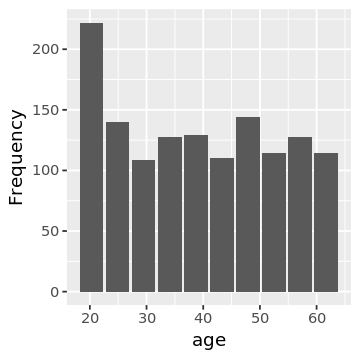

In [33]:
library(ggplot2)
options(repr.plot.width = 3, repr.plot.height = 3)
ggplot(histogram(df, 'age'), 
       aes(x = centroids, y = counts)) + 
geom_bar(stat = "identity") +
xlab("age") + ylab("Frequency")  

Muchas funciones de uso común en R no están disponibles en SparkR, por lo que resulta necesario usar `collect()` para obtener el contenido de la variable y luego aplicar la función requerida.

In [16]:
##
## Se obtienen las columnas numéricas
##
nonnum_columns <- c() 
for(x in dtypes(df)){
    if(x[2] == 'string') 
        nonnum_columns <- c(nonnum_columns, x[1])
}
nonnum_columns

[1] "sex"    "smoker" "region"

In [18]:
for(column in nonnum_columns){
    print(table(collect(select(df, column))))
}


female   male 
   662    676 

  no  yes 
1064  274 

northeast northwest southeast southwest 
      324       325       364       325 


No obstante, algunas veces es posible utilizar los operadores de agregación de SQL para realizar los cómputos equivalentes. En sl siguiente fragmento de código, se usa la función `groupBy` para calcular la cantidad de registros por región.

In [26]:
collect(summarize(groupBy(df,                  ## DataFrame
                          df$region),          ## Columna para realizar la agregación
                          count=n(df$region))) ## Cuenta la cantidad de registros por valor en quantity

region    count
1 northwest 325  
2 southeast 364  
3 northeast 324  
4 southwest 325

A continuación, se traen los datos al entorno local para calcula la correlación entre las columnas del DataFrame.

In [30]:
cor(collect(select(df, c("age", "bmi", "children", "charges"))))

age       bmi       children   charges   
age      1.0000000 0.1092719 0.04246900 0.29900819
bmi      0.1092719 1.0000000 0.01275890 0.19834097
children 0.0424690 0.0127589 1.00000000 0.06799823
charges  0.2990082 0.1983410 0.06799823 1.00000000

Este procedimiento de importación de datos, también puede usarse para construir gráficos.

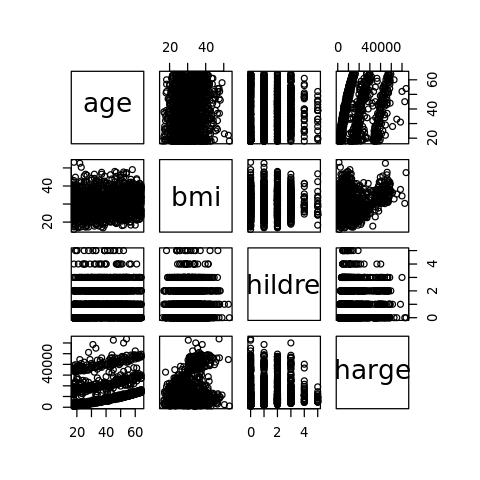

In [31]:
options(repr.plot.width = 4, repr.plot.height = 4)
pairs(collect(select(df, c("age", "bmi", "children", "charges"))))

### Construcción de modelos

#### Modelo de regresión lineal

A continuación se usa la función `spark.gml` para la especificación de modelos lineales generalizados. Una lista de los algoritmos disponibles en SparR puede ser consultada en https://spark.apache.org/docs/latest/sparkr.html#algorithms 

In [36]:
model <- spark.glm(
    df, 
    charges ~ age + children + bmi + sex + smoker + region, 
    family = "gaussian")

fitted_glm <- predict(model, df)

summary(model)


Deviance Residuals: 
(Note: These are approximate quantiles with relative error <= 0.01)
     Min        1Q    Median        3Q       Max  
-11304.9   -2857.9   -1043.9    1280.1   29992.8  

Coefficients:
                   Estimate  Std. Error    t value    Pr(>|t|)
(Intercept)        11910.00    1033.924   11.51922  0.00000000
age                  256.86      11.899   21.58666  0.00000000
children             475.50     137.804    3.45055  0.00057697
bmi                  339.19      28.599   11.86013  0.00000000
sex_male            -131.31     332.945   -0.39440  0.69334752
smoker_no         -23848.53     413.153  -57.72320  0.00000000
region_southeast   -1035.02     478.692   -2.16219  0.03078174
region_southwest    -960.05     477.933   -2.00876  0.04476493
region_northwest    -352.96     476.276   -0.74109  0.45876893

(Dispersion parameter for gaussian family taken to be 36749084)

    Null deviance: 1.9607e+11  on 1337  degrees of freedom
Residual deviance: 4.8840e+10  on 1329

La sintaxis sigue siendo similar a la tradicional en R. 

#### Gradient-boosted tree regression

In [41]:
##
## Se procede de igual manera que con el modelo
## de regresión lineal
##
model <- spark.gbt(
    df, 
    charges ~ age + children + bmi + sex + smoker + region, 
    maxIter = 20)

fitted_gbt <- predict(model, df)

#### summary(model)

#### Random forest regression

In [42]:
##
## Se procede de igual manera que con el modelo
## de regresión lineal
##
model <- spark.randomForest(
    df, 
    charges ~ age + children + bmi + sex + smoker + region)

fitted_rfr <- predict(model, df)

#### summary(model)

#### Resumen de resultados

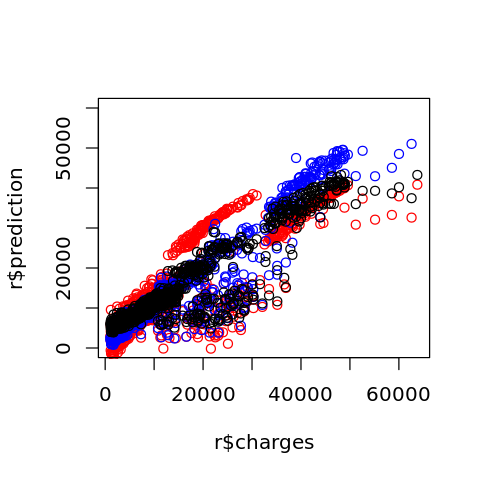

In [47]:
options(repr.plot.width = 4, repr.plot.height = 4)

r <- collect(select(fitted_glm, "charges", "prediction"))
plot(x=r$charges, r$prediction, col='red', ylim=c(0,60000))

r <- collect(select(fitted_gbt, "charges", "prediction"))
points(x=r$charges, r$prediction, col='blue')

r <- collect(select(fitted_rfr, "charges", "prediction"))
points(x=r$charges, r$prediction, col='black')

